# Error Analysis

Let's check out what's our model doing wrong

In [1]:
%load_ext autoreload
%autoreload 2
import os
from datetime import datetime
import fire
import torch
import pandas as pd
from torchtext import data
import torch.nn as nn
from transformers import (
    AdamW, BertForSequenceClassification, BertTokenizer,
    get_constant_schedule_with_warmup
)

from offenseval.nn import (
    Tokenizer,
    train, evaluate, train_cycle, save_model, load_model, evaluate_dataset
)
from offenseval.datasets import datasets

pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, TEXT = load_model("../models/bert_cased.all.pt", device)
model.eval();

/home/jmperez/.local/share/virtualenvs/offenseval2020-HKdlw5Be/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'offenseval.nn.models.bert_for_sequence.BertSeqModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jmperez/.local/share/virtualenvs/offenseval2020-HKdlw5Be/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'transformers.modeling_bert.BertSelfAttention' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Load the dataset as a `pd.DataFrame` (it could be done in the previous cell but well...)

In [3]:
from offenseval.nn.evaluation import evaluate
from offenseval.nn import EvaluationReport
from tqdm.auto import tqdm

dataset_path = datasets["english"]["test"]
report = evaluate_dataset(model, TEXT, dataset_path)

report


Loading dataset...
Building iterators


Acc: 91.46% Macro F1 0.899 (P 0.860 - N 0.939)

Create dataframe with predictions, probas, and so on

In [3]:
import csv

df = pd.read_table(dataset_path, index_col=0, 
                   quoting=csv.QUOTE_NONE)

df["label"] = df["subtask_a"] == 'OFF'

df["prob"] = report.probas.numpy()
df["pred"] = df["prob"] > 0.5


In [13]:
def calculate_confusion_matrix(df, label_col, pred_col):
    true_positives = df[df[label_col] & df[pred_col]].copy()
    true_negatives = df[~df[label_col] & ~df[pred_col]].copy()
    
    errors = df[df[label_col] != df[pred_col]]

    false_positives = errors[errors[pred_col]].copy()
    false_positives.sort_values(pred_col, ascending=False, inplace=True)

    false_negatives = errors[errors[label_col]].copy()
    false_negatives.sort_values(pred_col, ascending=True, inplace=True)

    return true_positives, true_negatives, false_positives, false_negatives

true_pos, true_neg, false_pos, false_neg = calculate_confusion_matrix(df, "label", "pred")

conf_matrix = pd.DataFrame([
    {"real":"not", "pred_false": len(true_neg), "pred_true": len(false_pos), },
    {"real":"off", "pred_false": len(false_neg), "pred_true": len(true_pos), },
])



conf_matrix.set_index("real", inplace=True)

print("Falsos negativos: {}".format(len(false_neg)))
print("Falsos positivos: {}".format(len(false_pos)))

conf_matrix

Falsos negativos: 62
Falsos positivos: 270


,pred_false,pred_true
real,,
not,2537,270
off,62,1018


Plot it as a heatmap so it's more graphical

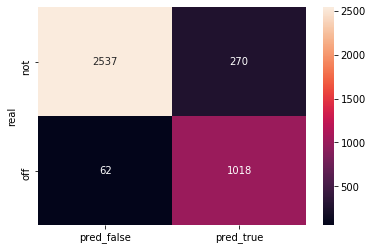

In [19]:
import seaborn as sns

sns.heatmap(conf_matrix, annot=True, fmt="")

Let's check out the false negatives. We have already ordered them by probability, so top rows are "worst" errors

In [21]:
false_neg

,tweet,subtask_a,label,prob,pred
id,,,,,
A18,Crazy that as we get older and go through certain shit you just want to keep it to yourself.,OFF,True,0.029142,False
A1944,I hadn’t been ok in a long time. Just been getting through the days and accomplishing shit so it seems a way.,OFF,True,0.010446,False
A1963,"WOW I NEVER REMEMBER TWEETING THIS BUT FACTSimagine someone told me to suck up my anxiety, lol why don’t you suck my dick instead",OFF,True,0.009070,False
A2100,@USER Sherry you yourself is a waste of seat in Senate!,OFF,True,0.001342,False
A2137,@USER You’re part of the problem and you’re inciting hatred and violence with your rhetoric.,OFF,True,0.046124,False
A2175,"@USER @USER Donald Trump is to blame. He has been perfecting his racist tactics for decades, and now we see the result.",OFF,True,0.003040,False
A2213,Yu Hate To See ItBitches will deadass lead you on &amp; go back to they ex😂,OFF,True,0.000642,False
A2322,@USER @USER If you're going to call someone a #dickhead check your spelling first #dickhead. It's you're not youre.,OFF,True,0.003509,False
A2333,@USER I don’t So far as you can recognize your Dad aa trash there’s no need to be talking to you,OFF,True,0.015773,False


In [22]:
false_pos

,tweet,subtask_a,label,prob,pred
id,,,,,
A32,One thing I hate most is a liar 🤥,NOT,False,0.998056,True
A2585,@USER A General that was trained to fight terrorist but only fight and kill unarmed protesters is that one a general? #lifeless,NOT,False,0.999408,True
A2337,@USER @USER If you think that was journalism last night WK I think you've lost it Buddy.,NOT,False,0.953363,True
A2344,what border agent let those snakes on a plane? did they have passports? i bet you those snakes did not have any legal identification,NOT,False,0.999450,True
A2345,@USER @USER You allow for one stupid law to come into play and the rest will follow.,NOT,False,0.998734,True
...,...,...,...,...,...
A1319,@USER I feel like the defenders of this record are trying too hard. Like you haven't heard that Gucci Mane feature? It's garbagio.,NOT,False,0.997321,True
A1323,"@USER Yeah my deck was insane that run, but normally I suck lol",NOT,False,0.999109,True
A1329,Sex is a scam but you can get it. Sis what???Write “Sex is” and let your keyboard complete the sentence for you. (mine below),NOT,False,0.997286,True


## Captum

See [this issue in github for an explanation](https://github.com/pytorch/captum/issues/150)

In [19]:
tokenizer_wrapper = TEXT.tokenize.__self__

bert_tokenizer = tokenizer_wrapper.bert_tokenizer

In [20]:
import torch
import torch.nn as nn

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, BertConfig

from captum.attr import IntegratedGradients
from captum.attr import InterpretableEmbeddingBase, TokenReferenceBase
from captum.attr import visualization
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [22]:



def compute_bert_outputs(model_bert, embedding_output, attention_mask=None, head_mask=None):
    if attention_mask is None:
        attention_mask = torch.ones(embedding_output.shape[0], embedding_output.shape[1]).to(embedding_output)

    extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

    extended_attention_mask = extended_attention_mask.to(dtype=next(model_bert.parameters()).dtype) # fp16 compatibility
    extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

    if head_mask is not None:
        if head_mask.dim() == 1:
            head_mask = head_mask.unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            head_mask = head_mask.expand(model_bert.config.num_hidden_layers, -1, -1, -1, -1)
        elif head_mask.dim() == 2:
            head_mask = head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)  # We can specify head_mask for each layer
        head_mask = head_mask.to(dtype=next(model_bert.parameters()).dtype) # switch to fload if need + fp16 compatibility
    else:
        head_mask = [None] * model_bert.config.num_hidden_layers

    encoder_outputs = model_bert.encoder(embedding_output,
                                         extended_attention_mask,
                                         head_mask=head_mask)
    sequence_output = encoder_outputs[0]
    pooled_output = model_bert.pooler(sequence_output)
    outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]  # add hidden_states and attentions if they are here
    return outputs  # sequence_output, pooled_output, (hidden_states), (attentions)    



class BertModelWrapper(nn.Module):
    
    def __init__(self, model):
        super(BertModelWrapper, self).__init__()
        self.model = model
        
    def forward(self, embeddings):        
        outputs = compute_bert_outputs(self.model.bert, embeddings)
        pooled_output = outputs[1]
        pooled_output = self.model.dropout(pooled_output)
        logits = self.model.classifier(pooled_output)
        return torch.sigmoid(logits).unsqueeze(1)

bert_model_wrapper = BertModelWrapper(model)
ig = IntegratedGradients(bert_model_wrapper)


In [30]:

# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model_wrapper, sentence, label=1):

    model_wrapper.eval()
    model_wrapper.zero_grad()
    
    input_ids = torch.tensor([bert_tokenizer.encode(sentence, add_special_tokens=True)]).to(device)
    input_embedding = model_wrapper.model.bert.embeddings(input_ids)
    
    # predict
    pred = model_wrapper(input_embedding).item()
    pred_ind = round(pred)

    # compute attributions and approximation delta using integrated gradients
    attributions_ig, delta = ig.attribute(input_embedding, n_steps=500, return_convergence_delta=True)

    print('pred: ', pred_ind, '(', '%.2f' % pred, ')', ', delta: ', abs(delta))

    tokens = bert_tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy().tolist())
    import ipdb; ipdb.set_trace()
    return create_vis_record(attributions_ig, tokens, pred, pred_ind, label, delta, vis_data_records_ig)
    
    
def create_attribution(attributions, tokens, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()
    
    # storing couple samples in an array for visualization purposes
    return visualization.VisualizationDataRecord(
        attributions,
        pred,
        pred_ind,
        label,
        "label",
        attributions.sum(),       
        tokens[:len(attributions)],
        delta
    )


interpret_sentence(bert_model_wrapper, sentence="This is my shit", label=0)
visualization.visualize_text(vis_data_records_ig)

pred:  1 ( 1.00 ) , delta:  tensor([0.0140], device='cuda:0')


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,1 (1.00),label,1.72,[CLS] This is my shi ##t [SEP]
